In [45]:
import os
import pandas as pd
import numpy as np

Path = '/Users/javieragazmuri/ConsiliumBots Dropbox/ConsiliumBots/Projects/Chile/Siblings/data/'

postulaciones = pd.read_csv(Path + 'intermediate/simulation_probabilities/inputs_for_joint_probabilities.csv')

riesgos = pd.read_csv(Path + 'intermediate/simulation_probabilities/riesgos_data-_oficialEqSAEAnterior_500r_exp0.csv')

postulaciones = pd.merge(postulaciones, riesgos, how = 'left', left_on =['rbd','codcurso','tipo'], right_on = ['rbd','cod_curso','tipo'], indicator = True)
postulaciones['_merge'].value_counts()

postulaciones.loc[(postulaciones['_merge'] == 'left_only'), 'risk'] = 0
del postulaciones['_merge']

# Prob. Mayor

In [46]:
# Filtramos la data

postulaciones_mayor = postulaciones.loc[(postulaciones.hermano_mayor == 1)]

# Calculando probabilidades de asignación

postulaciones_mayor = postulaciones_mayor.sort_values(['mrun','preferencia_postulante']).reset_index(drop=True)
postulaciones_mayor['prob_asig'] = np.nan
# Variable auxiliar
postulaciones_mayor['prob_acum'] = np.nan

# Loop

for i in range(0,len(postulaciones_mayor)):
    if postulaciones_mayor.loc[i,'preferencia_postulante'] == 1:
        postulaciones_mayor.loc[i,'prob_asig'] = 1 - postulaciones_mayor.loc[i,'risk']
        postulaciones_mayor.loc[i,'prob_acum'] = postulaciones_mayor.loc[i,'prob_asig']
    else:
        postulaciones_mayor.loc[i,'prob_asig'] = (1 - postulaciones_mayor.loc[i-1,'prob_acum']) * (1 - postulaciones_mayor.loc[i,'risk'])
        postulaciones_mayor.loc[i,'prob_acum'] = postulaciones_mayor.loc[i,'prob_asig'] + postulaciones_mayor.loc[i-1,'prob_acum']

mayor_no_asignado = postulaciones_mayor.groupby('mrun').agg({'prob_asig':'sum'}).reset_index()

mayor_no_asignado['prob_no_asignado'] = 1 - mayor_no_asignado['prob_asig']
del mayor_no_asignado['prob_asig']


# Prob. Menor

## Creando la data

In [47]:
# Filtramos la data

postulaciones_menor = postulaciones.loc[(postulaciones.hermano_mayor == 0)]

# Eliminamos riesgo porque los volveremos a obtener

del postulaciones_menor['risk']

# Eliminamos tipo porque lo volveremos a obtener

del postulaciones_menor['tipo']

# Pegamos las postulaciones del hermano mayor, para que cada el set de postulaciones del menor se repita para cada postulación del mayor

postulaciones_mayor_para_hermano = postulaciones_mayor[['mrun','prob_asig','rbd']]
postulaciones_mayor_para_hermano = postulaciones_mayor_para_hermano.rename(columns={'mrun': 'mrun_hermano_final', 'prob_asig': 'prob_asig_mayor', 'rbd': 'rbd_mayor'})

conjunto_postulaciones = pd.merge(postulaciones_menor, postulaciones_mayor_para_hermano, how = 'left', left_on = ['mrun_hermano_final'], right_on = ['mrun_hermano_final'], indicator = True)
conjunto_postulaciones['_merge'].value_counts()
# Todas las obs pegan :)
del conjunto_postulaciones['_merge']

# Hacemos append de las postulaciones del menor para sumar el caso en que el mayor no es asignado

mayor_no_asignado = mayor_no_asignado.rename(columns={'mrun': 'mrun_hermano_final', 'prob_no_asignado': 'prob_no_asignado_mayor'})
conjunto_no_asignado = pd.merge(postulaciones_menor, mayor_no_asignado, how = 'left', left_on = ['mrun_hermano_final'], right_on = ['mrun_hermano_final'], indicator = True)
conjunto_no_asignado['_merge'].value_counts()
# Todas las obs pegan :)
del conjunto_no_asignado['_merge']

conjunto_final = conjunto_postulaciones.append(conjunto_no_asignado)

# Ordenamos la data

conjunto_final = conjunto_final.sort_values(['mrun','rbd_mayor','preferencia_postulante']).reset_index(drop=True)


/var/folders/nx/hjv6fkdn3fnd8hv6fsj5qw0r0000gn/T/ipykernel_5809/4063525290.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conjunto_final = conjunto_postulaciones.append(conjunto_no_asignado)


## 1. Prioridad dinámica

In [48]:
# Reemplazamos prioridad por dinámica cuando corresponda

# 1. Reemplazamos la variable criterioprioridad 
# Se reemplaza por 4 cuando criterioprioridad < 4 y es el rbd correspondiente

conjunto_final.loc[(conjunto_final['criterioprioridad'] < 4) & (conjunto_final['rbd_mayor'] == conjunto_final['rbd']), 'criterioprioridad'] = 4
conjunto_final['criterioprioridad'].value_counts()

# 2. Pegamos con la base tipos

tipos = pd.read_csv('/Users/javieragazmuri/ConsiliumBots Dropbox/Javiera Gazmuri/Archivos de javiera@consiliumbots.com/ejemploJavi/tipos_data-data2022_5r_exp0.csv')

tipos = pd.read_csv(Path + 'intermediate/simulation_probabilities/tipos_data-_oficialEqSAEAnterior_500r_exp0.csv')

tipos = tipos.rename(columns={'criterioPrioridad': 'criterioprioridad'})
del tipos['criterioPrioridad_label']
del tipos['tipo_label']

conjunto_final = pd.merge(conjunto_final, tipos, how = 'left', left_on = ['criterioprioridad','prioritario','alto_rendimiento'], right_on = ['criterioprioridad','prioritario','alto_rendimiento'], indicator = True)
conjunto_final['_merge'].value_counts()
del conjunto_final['_merge']

conjunto_final = pd.merge(conjunto_final, riesgos, how = 'left', left_on =['rbd','codcurso','tipo'], right_on = ['rbd','cod_curso','tipo'], indicator = True)
conjunto_final['_merge'].value_counts()
conjunto_final.loc[(conjunto_final['_merge'] == 'left_only'), 'risk'] = 0
del conjunto_final['_merge']


## 2. Postulación familiar (para no activar postulación familiar, no se corre)

In [49]:
# Re-ordenamos preferencias por postulación en bloque

conjunto_final['dummy'] = 0
conjunto_final.loc[(conjunto_final['rbd_mayor'] == conjunto_final['rbd']), 'dummy'] = 1

# Indicador de que la postulacion del mayor esta en la del menor
conjunto_final['mrun_con_dummy'] = conjunto_final.groupby(['mrun','rbd_mayor'])['dummy'].transform('max')

# Variable que sirve para ver si es que el menor postulo a ese colegio en su primera preferencia
conjunto_final['num_preferencia'] = 0
conjunto_final.loc[(conjunto_final['rbd_mayor'] == conjunto_final['rbd']), 'num_preferencia'] = conjunto_final['preferencia_postulante']

conjunto_final['max_num_preferencia'] = conjunto_final.groupby(['mrun','rbd_mayor'])['num_preferencia'].transform('max')

# Reordenando
conjunto_final.loc[(conjunto_final['max_num_preferencia'] != 1) & (conjunto_final['max_num_preferencia'] != np.nan) & (conjunto_final['mrun_con_dummy']==1), 'preferencia_postulante'] = conjunto_final['preferencia_postulante'] + 1
conjunto_final.loc[(conjunto_final['max_num_preferencia'] != 1) & (conjunto_final['max_num_preferencia'] != np.nan) & (conjunto_final['mrun_con_dummy']==1) & (conjunto_final['rbd_mayor'] == conjunto_final['rbd']), 'preferencia_postulante'] = 1

# Creando nueva variable de preferencia_postulante
conjunto_final = conjunto_final.sort_values(['mrun','rbd_mayor','preferencia_postulante']).reset_index(drop=True)

conjunto_final['new_pref'] = 1
conjunto_final['new_pref'] = conjunto_final.groupby(['mrun','rbd_mayor']).cumcount() + 1

missing_rbd_mask = conjunto_final['rbd_mayor'].isnull()

conjunto_final.loc[missing_rbd_mask, 'new_pref'] = conjunto_final.loc[missing_rbd_mask, 'preferencia_postulante']

del conjunto_final['preferencia_postulante']
conjunto_final = conjunto_final.rename(columns={'new_pref': 'preferencia_postulante'})

## 3. Cálculo probabilidades

In [50]:
# Corremos la fórmula

# Calculando probabilidades de asignación

conjunto_final['prob_asig_menor_t'] = np.nan
# Variable auxiliar
conjunto_final['prob_acum_menor'] = np.nan

# Loop

for i in range(0,len(conjunto_final)):
    if conjunto_final.loc[i,'preferencia_postulante'] == 1:
        conjunto_final.loc[i,'prob_asig_menor_t'] = 1 - conjunto_final.loc[i,'risk']
        conjunto_final.loc[i,'prob_acum_menor'] = conjunto_final.loc[i,'prob_asig_menor_t']
    else:
        conjunto_final.loc[i,'prob_asig_menor_t'] = (1 - conjunto_final.loc[i-1,'prob_acum_menor']) * (1 - conjunto_final.loc[i,'risk'])
        conjunto_final.loc[i,'prob_acum_menor'] = conjunto_final.loc[i,'prob_asig_menor_t'] + conjunto_final.loc[i-1,'prob_acum_menor']



In [51]:
# Obteniendo las probabilidades finales

conjunto_final['prob_asig_menor'] = conjunto_final['prob_asig_mayor'] * conjunto_final['prob_asig_menor_t'] 

prob_asignaciones_menor = conjunto_final.groupby(['mrun','rbd']).agg({'prob_asig_menor':'sum'}).reset_index()

postulaciones_menor = pd.merge(postulaciones_menor, prob_asignaciones_menor, how = 'left', left_on =['mrun','rbd'], right_on = ['mrun','rbd'], indicator = True)
postulaciones_menor['_merge'].value_counts()

both          193358
left_only          0
right_only         0
Name: _merge, dtype: int64

In [52]:
# Probabilidad de no asignación

menor_no_asignado = postulaciones_menor.groupby('mrun').agg({'prob_asig_menor':'sum', 'mrun_hermano_final':'mean'}).reset_index()

menor_no_asignado['prob_no_asignado'] = 1 - menor_no_asignado['prob_asig_menor']
del menor_no_asignado['prob_asig_menor']

menor_no_asignado = menor_no_asignado.rename(columns={'mrun': 'mrun_menor'})


# Prob. conjuntas

In [53]:
# Menor

prob_menor = postulaciones_menor[['mrun','rbd','codcurso','preferencia_postulante','prob_asig_menor','mrun_hermano_final']]
prob_menor = prob_menor.rename(columns={'mrun': 'mrun_menor', 'preferencia_postulante': 'preferencia_menor','rbd':'rbd_menor', 'codcurso': 'cod_curso_menor'})

prob_menor = prob_menor.append(menor_no_asignado)

prob_menor = prob_menor.sort_values(['mrun_menor','preferencia_menor']).reset_index(drop=True)

missing_rbd_mask = prob_menor['preferencia_menor'].isnull()

prob_menor.loc[missing_rbd_mask, 'prob_asig_menor'] = prob_menor.loc[missing_rbd_mask, 'prob_no_asignado']
del prob_menor['prob_no_asignado']

# Mayor

prob_mayor = postulaciones_mayor[['mrun','rbd','codcurso','preferencia_postulante','prob_asig']]
mayor_no_asignado = mayor_no_asignado.rename(columns={'mrun_hermano_final': 'mrun'})

prob_mayor = prob_mayor.append(mayor_no_asignado)

prob_mayor = prob_mayor.sort_values(['mrun','preferencia_postulante']).reset_index(drop=True)

missing_rbd_mask = prob_mayor['preferencia_postulante'].isnull()

prob_mayor.loc[missing_rbd_mask, 'prob_asig'] = prob_mayor.loc[missing_rbd_mask, 'prob_no_asignado_mayor']
del prob_mayor['prob_no_asignado_mayor']

prob_mayor = prob_mayor.rename(columns={'mrun': 'mrun_hermano_final', 'preferencia_postulante': 'preferencia_mayor','prob_asig': 'prob_asig_mayor', 'rbd':'rbd_mayor','codcurso':'cod_curso_mayor'})

# Merging datasets

prob_conjunta = pd.merge(prob_menor, prob_mayor, how = 'left', left_on = 'mrun_hermano_final', right_on = 'mrun_hermano_final', indicator = True)
prob_conjunta['_merge'].value_counts()
del prob_conjunta['_merge']

# Probabilidad conjunta

prob_conjunta['prob_conjunta'] = prob_conjunta['prob_asig_menor'] * prob_conjunta['prob_asig_mayor']

prob_conjunta = prob_conjunta.sort_values(['mrun_menor','prob_conjunta'], ascending = False).reset_index(drop=True)

prob_conjunta['auxiliar'] = 1
prob_conjunta['auxiliar'] = prob_conjunta.groupby(['mrun_menor']).cumcount() + 1

# Con auxiliar = 1 y = 2 podemos identificar los dos eventos con mayor probabilidad.

/var/folders/nx/hjv6fkdn3fnd8hv6fsj5qw0r0000gn/T/ipykernel_5809/2323021080.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prob_menor = prob_menor.append(menor_no_asignado)
/var/folders/nx/hjv6fkdn3fnd8hv6fsj5qw0r0000gn/T/ipykernel_5809/2323021080.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prob_mayor = prob_mayor.append(mayor_no_asignado)


# Estadística

In [54]:
# Describiendo los eventos

# 1. Necesitamos la matrícula asegurada 

matricula_asegurada = postulaciones[['mrun','rbd','criterioprioridad']]
matricula_asegurada = matricula_asegurada[matricula_asegurada['criterioprioridad'] == 6]
del matricula_asegurada['criterioprioridad']

matricula_asegurada_menor = matricula_asegurada.rename(columns={'mrun': 'mrun_menor', 'rbd': 'rbd_mat_aseg_menor'})
matricula_asegurada_mayor = matricula_asegurada.rename(columns={'mrun': 'mrun_hermano_final', 'rbd': 'rbd_mat_aseg_mayor'})

prob_conjunta = pd.merge(prob_conjunta,matricula_asegurada_menor, how = 'left', left_on = 'mrun_menor', right_on = 'mrun_menor')
prob_conjunta = pd.merge(prob_conjunta,matricula_asegurada_mayor, how = 'left', left_on = 'mrun_hermano_final', right_on = 'mrun_hermano_final')

# En vez de que aparezca el nº con la preferencia, pondremos matrícula asegurada

prob_conjunta.loc[prob_conjunta['rbd_menor'] == prob_conjunta['rbd_mat_aseg_menor'], 'preferencia_menor'] = 'mat_aseg'
prob_conjunta.loc[prob_conjunta['rbd_mayor'] == prob_conjunta['rbd_mat_aseg_mayor'], 'preferencia_mayor'] = 'mat_aseg'

# Creando variable que combina ambas preferencias

# Convert 'preferencia_menor' and 'preferencia_mayor' columns to strings
prob_conjunta['preferencia_menor'] = prob_conjunta['preferencia_menor'].astype(str)
prob_conjunta['preferencia_mayor'] = prob_conjunta['preferencia_mayor'].astype(str)

prob_conjunta.loc[prob_conjunta['preferencia_menor'] == 'nan', 'preferencia_menor'] = 'no_asig'
prob_conjunta.loc[prob_conjunta['preferencia_mayor'] == 'nan', 'preferencia_mayor'] = 'no_asig'

# Concatenate 'preferencia_mayor' and 'preferencia_menor' columns with ':' separator
prob_conjunta['evento'] = prob_conjunta['preferencia_mayor'] + ':' + prob_conjunta['preferencia_menor']

# Viendo cómo se caracterizan los dos eventos más probables
prob_conjunta.loc[prob_conjunta['auxiliar'].isin([1, 2]), 'evento'].value_counts().head(10)

1.0:1.0              27598
mat_aseg:mat_aseg    13097
2.0:1.0              12272
mat_aseg:1.0         10371
no_asig:no_asig       6085
1.0:mat_aseg          5662
mat_aseg:2.0          4347
2.0:2.0               4299
1.0:2.0               3905
2.0:mat_aseg          2675
Name: evento, dtype: int64

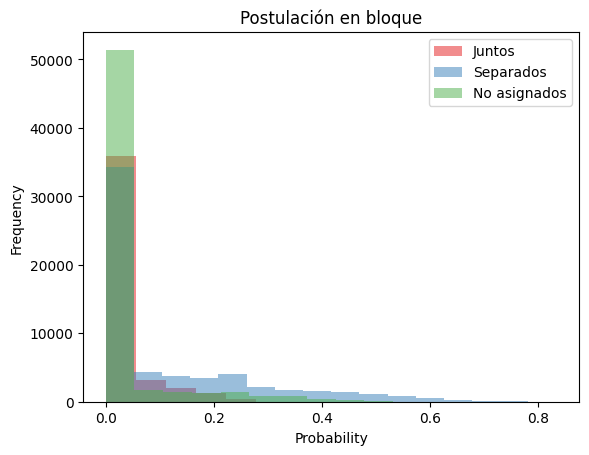

In [56]:
# Prob. otros eventos

# juntos
juntos = prob_conjunta.loc[(prob_conjunta['auxiliar'] > 2) & (prob_conjunta['rbd_menor'] == prob_conjunta['rbd_mayor']), ]
juntos = juntos.groupby('mrun_menor').agg({'prob_conjunta':'sum'}).reset_index()

# separados
separados = prob_conjunta.loc[(prob_conjunta['auxiliar'] > 2) & (prob_conjunta['rbd_menor'] != prob_conjunta['rbd_mayor']), ]
separados = separados.groupby('mrun_menor').agg({'prob_conjunta':'sum'}).reset_index()

# no asignados
no_asignados = prob_conjunta.loc[(prob_conjunta['auxiliar'] > 2) & (prob_conjunta['rbd_menor'].isnull() | prob_conjunta['rbd_mayor'].isnull()), ]
no_asignados = no_asignados.groupby('mrun_menor').agg({'prob_conjunta':'sum'}).reset_index()

# Histograma 

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('Set1')

bin_width = 0.05

data_min_j = juntos['prob_conjunta'].min()
data_max_j = juntos['prob_conjunta'].max()
num_bins_j = int((data_max_j - data_min_j) / bin_width)

data_min_s = separados['prob_conjunta'].min()
data_max_s = separados['prob_conjunta'].max()
num_bins_s = int((data_max_s - data_min_s) / bin_width)

data_min_n = no_asignados['prob_conjunta'].min()
data_max_n = no_asignados['prob_conjunta'].max()
num_bins_n = int((data_max_n - data_min_n) / bin_width)


plt.hist(juntos['prob_conjunta'], bins=num_bins_j, range =(data_min_j, data_max_j), alpha=0.5, label='Juntos')
plt.hist(separados['prob_conjunta'], bins=num_bins_s, range =(data_min_s, data_max_s) , alpha=0.5, label='Separados')
plt.hist(no_asignados['prob_conjunta'], bins=num_bins_n, range =(data_min_n, data_max_n), alpha=0.5, label='No asignados')

plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Postulación en bloque')
plt.legend()
plt.show()
